In [2]:
import sys
import gc
from pathlib import Path
sys.path.append('/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/plots')

import lowda

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from scipy.optimize import curve_fit

In [3]:
import importlib
importlib.reload(lowda);

In [4]:
name = 'MW4_MHG0.25_GSE2_MHG0.5'
nameiso = 'MW4iso_fg0.2_MHG0.25_RC9'
lvl = 'lvl4-noB'

idx_list = [0, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]

In [5]:
galiso = lowda.load_gal(nameiso, lvl, fields=None, idx_list=idx_list, parttype=None)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4iso_fg0.2_MHG0.25_RC9  took  00:00:27


In [6]:
galisoB = lowda.load_gal(nameiso, 4, fields=None, idx_list=idx_list, parttype=None)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4iso_fg0.2_MHG0.25_RC9  took  00:00:18


In [7]:
gal = lowda.load_gal(name, lvl, fields=None, idx_list=idx_list, parttype=None)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4_MHG0.25_GSE2_MHG0.5  took  00:00:44


In [8]:
def get_n_T(sn):
    UnitLength = sn.parameters.UnitLength_in_cm
    UnitMass = sn.parameters.UnitMass_in_g
    UnitVelocity = sn.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

    InternalEnergy = sn.part0.InternalEnergy.value
    ElectronAbundance = sn.part0.ElectronAbundance
    Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [9]:
galiso['idx_list']

[0, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]

In [10]:
def get_stuff(gal, idx):
    i = gal['i_from_idx'][idx]
    sn = gal['sn_idx'][idx]
    COM = gal['MW_COM'][i]
    COMV = gal['MW_COMV'][i]

    G = 43018.7

    UnitMass_in_g = sn.parameters.UnitMass_in_g
    UnitLength_in_cm = sn.parameters.UnitLength_in_cm
    UnitVelocity_in_cm_per_s = sn.parameters.UnitVelocity_in_cm_per_s
    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitPressure_in_cgs = UnitMass_in_g / UnitLength_in_cm / (UnitTime_in_s**2)
    UnitDensity_in_cgs = UnitMass_in_g / (UnitLength_in_cm)**3
    UnitEnergy_in_cgs = UnitMass_in_g * (UnitLength_in_cm/UnitTime_in_s)**2

    mass = sn.part0.mass.value
    pos = sn.part0.pos.value - COM
    vel = sn.part0.vel.value - COMV

    r = np.linalg.norm(pos, axis=1)
    v = np.linalg.norm(vel, axis=1)

    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]

    tflow = np.abs(r/vr)

    P = sn.part0.Pressure.value * UnitPressure_in_cgs
    GAMMA = 5./3.
    Lambda = -sn.part0.GFM_CoolingRate
    n, T = get_n_T(sn)

    C = n**2 * Lambda # in units of erg/s/cm^3
    C /= UnitEnergy_in_cgs / UnitTime_in_s / (UnitLength_in_cm)**3
    energy = sn.part0.rho.value * sn.part0.u.value

    tcool = energy/C
    cssq = sn.part0.SoundSpeed**2

    passcalar = sn.part0.PassiveScalars * sn.part0.Masses.reshape(-1, 1)
    
    return r, vr, T

In [11]:
np.sum(passcalar, axis=0)

NameError: name 'passcalar' is not defined

In [12]:
r_pt = {}
for pt in range(6):
    if sn.NumPart_Total[pt] > 0:
        part = getattr(sn, 'part'+str(pt))
        r_pt[pt] = np.linalg.norm(part.rotpos, axis=1)

renclist       = np.linspace(1, 200, 200)

Menc           = np.zeros_like(renclist)
cssqlist       = np.zeros_like(renclist)
Tlist          = np.zeros_like(renclist)
tcoollist      = np.zeros_like(renclist)
tflowlist      = np.zeros_like(renclist)
vlist          = np.zeros_like(renclist)
vrlist         = np.zeros_like(renclist)
passcalar_list = np.zeros((len(renclist), 4))

dr = 1.0
for i,renc in enumerate(renclist):
    for pt in r_pt.keys():
        part = getattr(sn, 'part'+str(pt))
        key = r_pt[pt] < renc
        if sn.MassTable[pt] == 0:
            Menc[i] += np.sum(part.mass.value[key])
        else:
            Menc[i] += sn.MassTable[pt] * np.sum(key)
        
    key          = np.logical_and(r_pt[0] > renc - dr/2., r_pt[0] < renc + dr/2.)
    cssqlist[i]  = np.mean(cssq[key])
    Tlist[i]     = np.mean(T[key])
    tcoollist[i] = np.mean(tcool[key])
    tflowlist[i] = np.mean(tflow[key])
    vlist[i]     = np.mean(v[key])
    vrlist[i]    = np.mean(vr[key])
    
    for j in range(4):
        passcalar_list[i][j] = np.sum(passcalar[key,j])
    
vcsq = G*Menc/renclist
vc = np.sqrt(vcsq)
tfflist = np.sqrt(2) * renclist / vc

NameError: name 'sn' is not defined

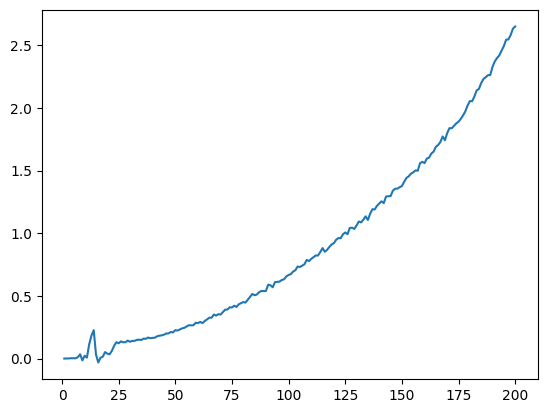

In [65]:
plt.plot(renclist, tcoollist)

A_opt: 286.9358069861301
m_opt: -0.2437509557580399
B: 0.6749987256559469


(0.0, 200.0)

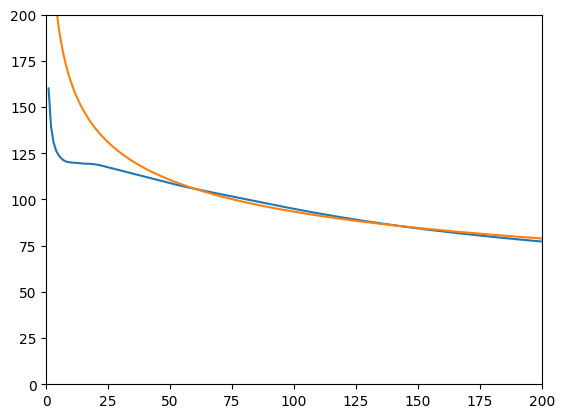

In [25]:
def power_law(x, A, m):
    return A * x**m

key = renclist > 40

popt, pcov = curve_fit(power_law, renclist[key], vc[key], (1.0, 0.0))

A_opt, m_opt = popt
print('A_opt:', A_opt)
print('m_opt:', m_opt)

print('B:', 1 + 4*m_opt/3)

plt.plot(renclist, vc)
plt.plot(renclist, power_law(renclist, A_opt, m_opt))
plt.xlim(0, 200)
plt.ylim(0, 200)

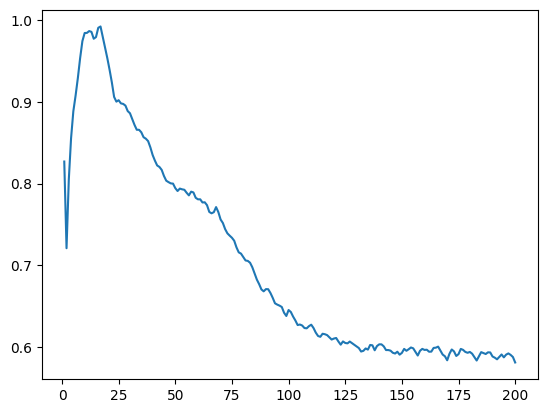

In [69]:
dvdr = np.gradient(vc, renclist)
m = (renclist/vc)*dvdr
# plt.plot(renclist, m)
plt.plot(renclist, 1 + 4*m/3)

Text(0.5, 0, 'r [kpc]')

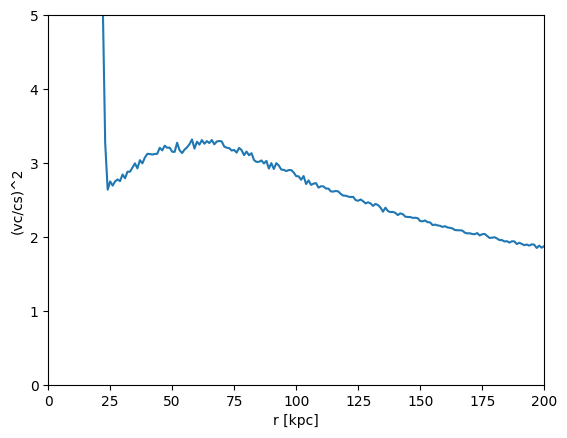

In [27]:
plt.plot(renclist, vcsq/cssqlist)
m = -0.6
# plt.axhline(0.9*(1-2*m))
plt.ylim(0, 5)
plt.xlim(0, 200)
plt.ylabel('(vc/cs)^2')
plt.xlabel('r [kpc]')

Text(0.5, 0, 'r [kpc]')

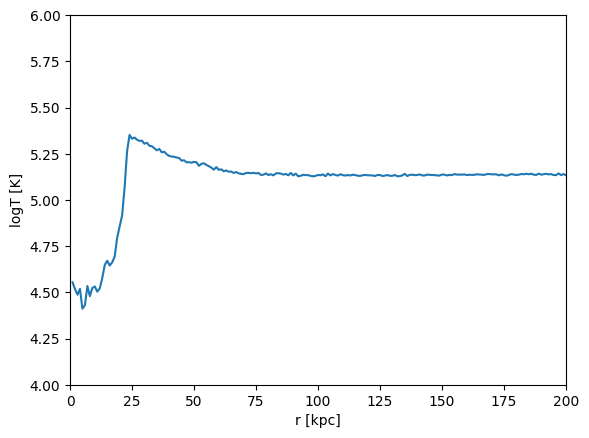

In [28]:
plt.plot(renclist, np.log10(Tlist))
plt.ylim(4, 6)
plt.xlim(0, 200)
plt.ylabel('logT [K]')
plt.xlabel('r [kpc]')

In [298]:
1-4/9

0.5555555555555556

B= 0.20000000000000007


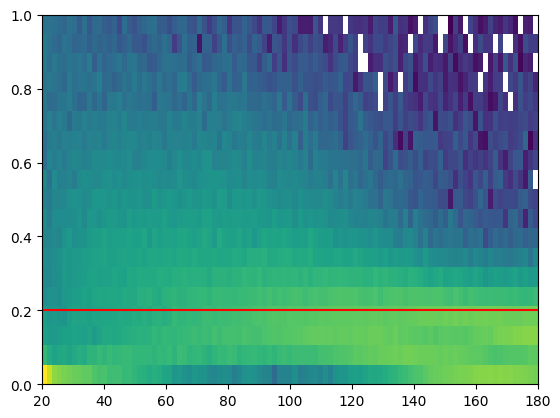

In [29]:
fig, ax = plt.subplots(1, 1)

xbins = np.linspace(20, 180, 100)
ybins = np.linspace(0, 1, 20)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m = np.full(len(r), mass/(dx*dy))
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, tcool/tflow, m,
                                                  statistic='sum', bins=(xbins, ybins))

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm())
ax.set_aspect('auto')

m = -0.6
B = 1+4*m/3
print('B=', B)
ax.axhline(B, c='r')
# ax.set_yscale('log')
# ax.set_title('isolated')

(0.0, 10.0)

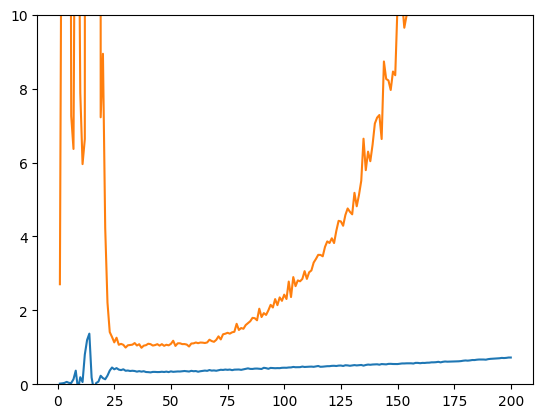

In [76]:
mach = np.abs(vrlist)/np.sqrt(cssqlist)
plt.plot(renclist, tcoollist/tfflist)

A = 0.9*(1-2*m)
B = 1 + (4/3)*m
# print(np.sqrt(A/2)/B)
plt.plot(renclist, np.sqrt(A/2)/B/mach)
plt.ylim(0, 10)

[Text(0.5, 0, 'r [kpc]'), Text(0, 0.5, 'logT [K]')]

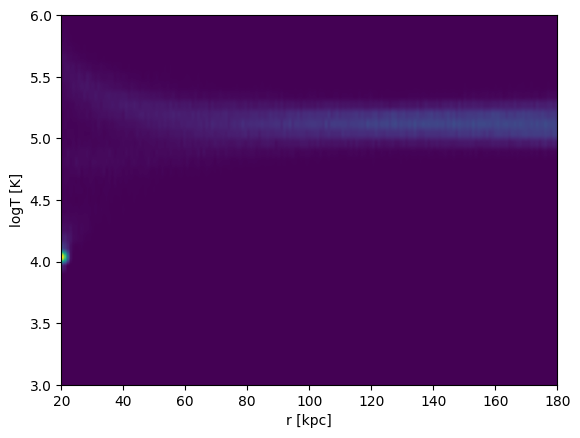

In [31]:
fig, ax = plt.subplots(1, 1)

xbins = np.linspace(20, 180, 180)
ybins = np.linspace(3, 6, 40)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m = np.full(len(r), mass/(dx*dy))
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, np.log10(T), m,
                                                  statistic='sum', bins=(xbins, ybins))

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent)
ax.set_aspect('auto')
ax.set(xlabel='r [kpc]', ylabel='logT [K]')
# ax.set_yscale('log')
# ax.set_title('isolated')

(0.0, 4e-05)


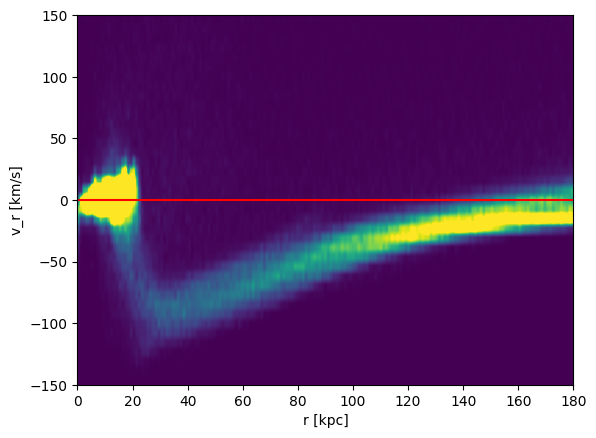

In [81]:
fig, ax = plt.subplots(1, 1)

xbins = np.linspace(0, 180, 180)
ybins = np.linspace(-150, 150, 40)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

vmin=0
vmax=4e-5

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m = np.full(len(r), mass/(dx*dy))
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(xbins, ybins))

m_in_bin /= dx*dy

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent, vmin=vmin, vmax=vmax)#, norm=mpl.colors.LogNorm())
print(im.get_clim())
ax.set_aspect('auto')
ax.set(xlabel='r [kpc]', ylabel='v_r [km/s]')
ax.axhline(0, c='r')
# ax.set_yscale('log')
# ax.set_title('isolated')

In [133]:
idx = 400
r, vr, T = get_stuff(gal, idx)
r_iso, vr_iso, T_iso = get_stuff(galiso, idx)
mass = gal['sn_idx'][idx].part0.mass.value * gal['sn_idx'][idx].part0.PassiveScalars[:,1]
mass_iso = galiso['sn_idx'][idx].part0.mass.value * galiso['sn_idx'][idx].part0.PassiveScalars[:,1]

(0.0, 0.0001)


[Text(0, 0.5, 'v_r [km/s]')]

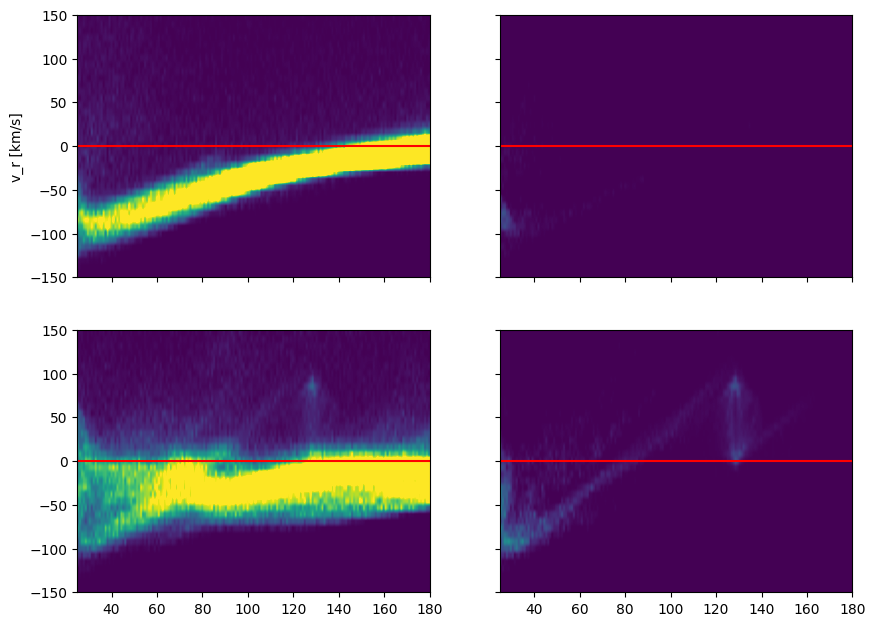

In [140]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7.5))

xbins = np.linspace(25, 180, 180)
ybins = np.linspace(-150, 150, 40)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
logTcut = 4.5

vmin=0
vmax=1e-4

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

# iso all scalar gas
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r_iso, vr_iso, mass_iso,
                                                  statistic='sum', bins=(xbins, ybins))
m_in_bin /= dx*dy
im = ax[0][0].imshow(m_in_bin.T, origin='lower', extent=extent, vmin=vmin, vmax=vmax)

# iso cold scalar gas
key = np.log10(T_iso) < logTcut
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r_iso[key], vr_iso[key], mass_iso[key],
                                                  statistic='sum', bins=(xbins, ybins))
m_in_bin /= dx*dy
im = ax[0][1].imshow(m_in_bin.T, origin='lower', extent=extent, vmin=vmin, vmax=vmax)

# merger all scalar gas
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, mass,
                                                  statistic='sum', bins=(xbins, ybins))
m_in_bin /= dx*dy
im = ax[1][0].imshow(m_in_bin.T, origin='lower', extent=extent, vmin=vmin, vmax=vmax)

# merger cold scalar gas
key = np.log10(T) < logTcut
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[key], vr[key], mass[key],
                                                  statistic='sum', bins=(xbins, ybins))
m_in_bin /= dx*dy
im = ax[1][1].imshow(m_in_bin.T, origin='lower', extent=extent, vmin=vmin, vmax=vmax)

print(im.get_clim())

for x in ax.ravel():
    x.set_aspect('auto')
    x.axhline(0, c='r')
ax[0][0].set(ylabel='v_r [km/s]')


In [127]:
print(r.shape)
print(vr.shape)
print(mass.shape)

(550936,)
(550936,)
(566029,)


In [128]:
gal['sn_idx'][idx].NumPart_Total[0]

566029